# Machine Learning - Route Optimization example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)](https://medium.com/towards-data-science/modern-route-optimization-with-python-fea87d34288b)

### 0 - Setup

In [1]:
!pip install scikit-learn

In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 5.5 MB/s eta 0:00:00


In [3]:
!pip install -U ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


###### Import pckgs

In [4]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0
from tqdm import tqdm

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

###### Import data

**I first extracted the locations of all McDonald's in Switzerland and Liechtenstein as CSV. We read them with pandas.**

In [5]:
dtf = pd.read_csv('md_ch.csv', sep=";")
print("Columns:", dtf.columns)
print("tot:", len(dtf))
dtf.head(3)

Columns: Index(['@type', '@id', '@lat', '@lon'], dtype='object')
tot: 175


,@type,@id,@lat,@lon
0,node,9332247,46.684532,7.853794
1,node,60467930,47.050810,9.058718
2,node,92612575,47.364808,8.531360


In [6]:
# Location of the warehouse that delivers McDonald's Switzerland
depot_id = 298475030
depot_lat = 47.2842438
depot_lon = 7.7214681

dtf.head(3)

,@type,@id,@lat,@lon
0,node,9332247,46.684532,7.853794
1,node,60467930,47.050810,9.058718
2,node,92612575,47.364808,8.531360


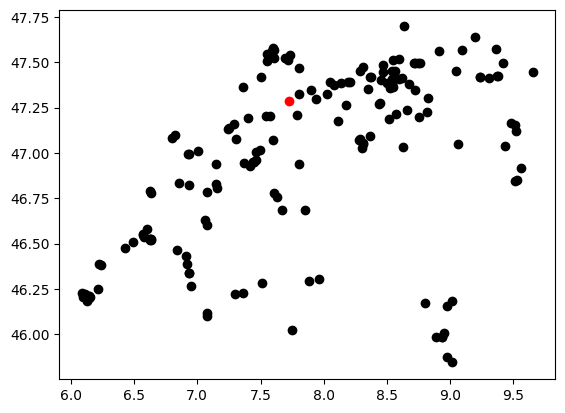

In [7]:
plt.scatter(y=dtf["@lat"], x=dtf["@lon"], color="black")
plt.scatter(y=depot_lat, x=depot_lon, color="red")
plt.show()

Extract the network of highways and main roads (this is less than network_type=drive) in Switzerland and Liechtenstein.
This takes around 8 Minutes and the resulting graph has 29550 nodes.

In [8]:
# Create network graph
G_orig = ox.graph_from_place(["Switzerland", "Liechtenstein"], custom_filter='["highway"~"motorway|motorway_link|primary|secondary|tertiary"]')
print(len(G_orig))

29556


Extract the local road network in a box (distance 800m) around each restaurant.

1/175: (46.684532, 7.8537943)
469
2/175: (47.0508104, 9.0587185)
436
3/175: (47.3648083, 8.5313604)
654
4/175: (47.2120922, 7.7911232)
515
5/175: (47.3234955, 7.8050545)
321
6/175: (47.451336, 8.290221)
152
7/175: (47.473928, 8.3069959)
423
8/175: (47.3767165, 8.5403343)
768
9/175: (47.3501562, 8.7183192)
533
10/175: (47.5259654, 7.6042811)
367
11/175: (47.0943531, 8.3625892)
560
12/175: (46.9481593, 7.4476543)
578
13/175: (46.21804, 6.1149938)
497
14/175: (47.2256015, 8.8160543)
241
15/175: (47.450885, 8.5406132)
296
16/175: (46.5108846, 6.4939929)
836
17/175: (46.5175523, 6.629373)
867
18/175: (46.5224653, 6.6306119)
840
19/175: (46.4745832, 6.4244968)
279
20/175: (46.2090171, 6.1441096)
621
21/175: (46.7803247, 6.6365233)
1095
22/175: (47.2980054, 7.9357867)
377
23/175: (47.3734328, 8.5297366)
926
24/175: (47.0046419, 7.4630132)
256
25/175: (46.5822654, 6.6013926)
318
26/175: (46.3397611, 6.931637)
133
27/175: (46.003695, 8.9538428)
266
28/175: (47.1669851, 9.4776693)
456
29/175: (4

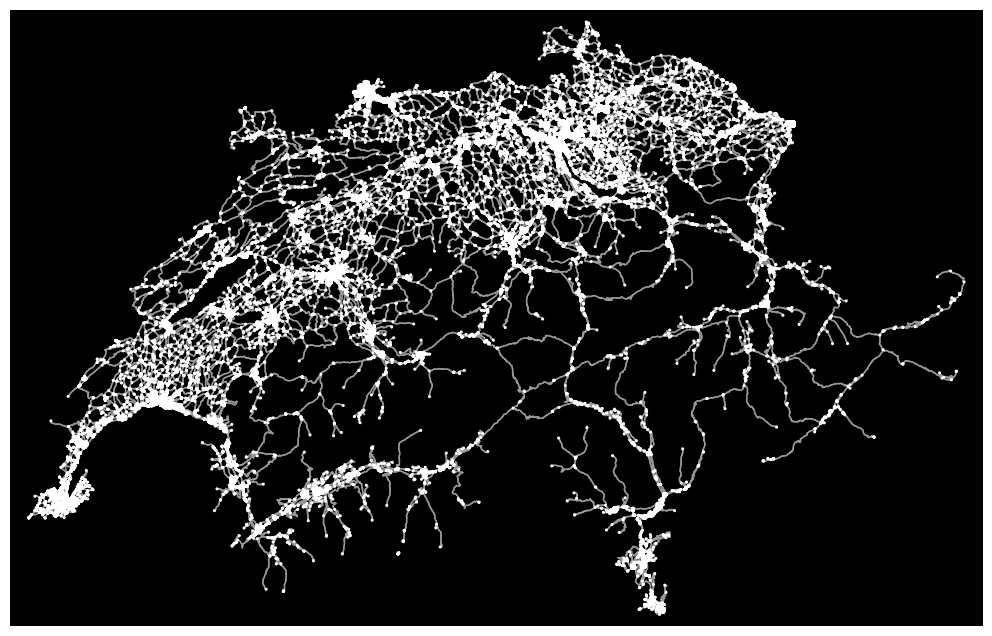

In [9]:
ox.settings.bidirectional_network_types.append("drive_service")

G_restaurants = []
for i in range(len(dtf)):
  coord = (dtf.loc[i,"@lat"], dtf.loc[i,"@lon"])
  print(f"{i+1}/{len(dtf)}: {coord}")
  G_restaurants.append(ox.graph_from_point(center_point=coord, dist=800, dist_type="bbox", network_type="drive_service", retain_all=True))
  print(len(G_restaurants[-1]))

G_restaurants_all = nx.compose_all(G_restaurants)
G = nx.compose(G_restaurants_all, G_orig)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

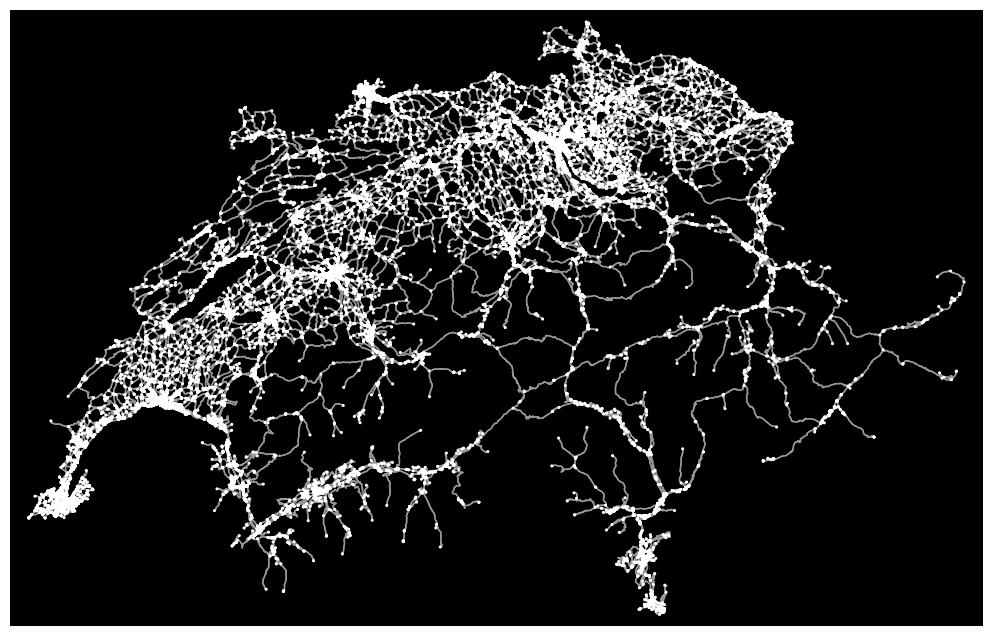

In [10]:
G = ox.add_edge_speeds(G_orig)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [11]:
# Save the network
filepath = "./md_ch.graphml"
ox.save_graphml(G, filepath)

In [12]:
# Load the network
filepath = "./md_ch.graphml"
G = ox.load_graphml(filepath)

In [ ]:
# Plot

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

###### Dijkstra Algorithm

In [13]:
'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param (y,x): str - columns with (latitude, longitude)
    :param starting_point: list - (latitude, longitude)
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, y, x, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)

    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain",
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl(position='bottomright').add_to(map_)

    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))

    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False,
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1)
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False,
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)

    ## full screen
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    return map_

### 3 - Preprocessing

###### Distance Matrix

In [14]:
# Add the depot to the dataframe. s.t. we also include it in the distance matrix
df = dtf
df["depot"] = False
df = df.append({"@type":"node", "@id": depot_id, "@lat": depot_lat, "@lon": depot_lon, "depot": True}, ignore_index=True)
df.tail()

,@type,@id,@lat,@lon,depot
171,node,4600483587,45.985352,8.936538,False
172,node,8364086381,46.114159,7.077402,False
173,node,10221298174,46.919339,9.562560,False
174,node,10282094953,47.151727,9.511577,False
175,node,298475030,47.284244,7.721468,True


In [15]:
print(len(G))
G_scc = ox.utils_graph.get_largest_component(G, strongly=True)
print(len(G_scc))

29556
28960


We use the osm-node the is closest to each location in the largest strongly connected component of the graph. This avoids that we choose nodes that are not reachable from each other. Otherwise we would get a lot of NaN values.

In [16]:
df["node_closest_road"] = [x[1] for x in ox.distance.nearest_edges(G_scc,df["@lon"],df["@lat"])]

In [ ]:
# This block generates the distance matrix. the distance matrix takes time to generate
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except Exception as e:
        print(e)
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a,b) for b in df["node_closest_road"].tolist()] for a in df["node_closest_road"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=df["node_closest_road"].values, index=df["node_closest_road"].values)
distance_matrix.head()
distance_matrix.to_csv("distance_matrix_travel_time.csv")

In [17]:
# Saving the distance matrix.
distance_matrix = pd.read_csv("distance_matrix_travel_time.csv", index_col=0)

In [ ]:
distance_matrix.head()

Check that there are actuall no NaN and inf values.

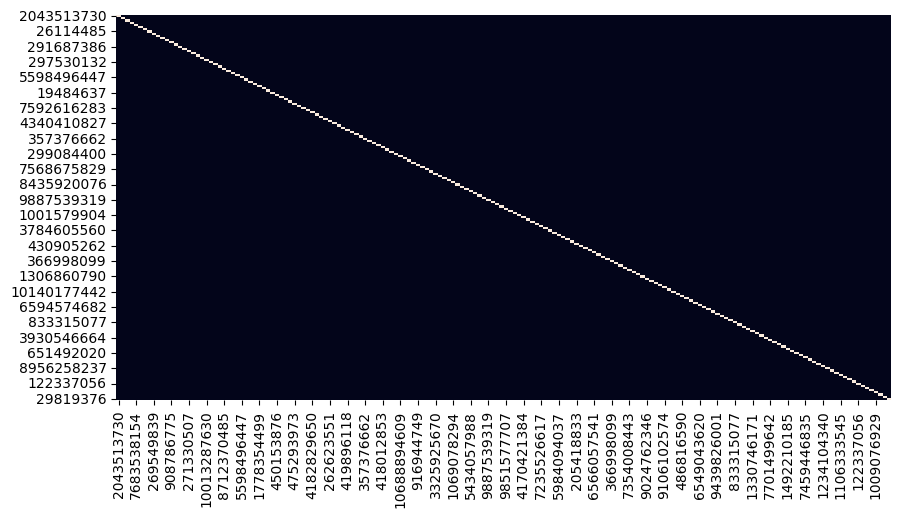

In [18]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

### 4 - Vehicle Routing Problem

###### Model

In [19]:
lst_nodes = df["node_closest_road"].tolist()
## Business parameters
drivers = 10
driver_capacities = [20]* drivers
demands = [1]*(len(lst_nodes)-1) + [0]
max_distance = 10000


In [20]:
start_node = lst_nodes[-1]
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)

start: 29819376 | tot locations to visit: 175 | drivers: 10


In [21]:
## model
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix.iloc[from_node,to_node]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

## add capacity (costraint)
def get_demand(from_index):
    from_node = manager.IndexToNode(from_index)
    return demands[from_node]

demand = model.RegisterUnaryTransitCallback(get_demand)
model.AddDimensionWithVehicleCapacity(demand, slack_max=0,
                                      vehicle_capacities=driver_capacities,
                                      fix_start_cumul_to_zero=True,
                                      name='Capacity')

## add limited distance (costraint)
name = 'Distance'
model.AddDimension(distance, slack_max=0, capacity=max_distance,
                   fix_start_cumul_to_zero=True, name=name)
distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

## set strategy to minimize cost (distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

## solution
dic_routes_idx, total_distance, total_load = {}, 0, 0
for driver in range(drivers):
    print(f'Route for driver {driver}:')
    index = model.Start(driver)
    route_idx, route_distance, route_load = [], 0, 0
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route_idx.append( manager.IndexToNode(index) )
        previous_index = index
        index = solution.Value( model.NextVar(index) )
        ### update distance
        try:
            route_distance += get_distance(previous_index, index)
        except:
            route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=driver)
        ### update load
        route_load += demands[node_index]

    route_idx.append( manager.IndexToNode(index) )
    print(route_idx)
    dic_routes_idx[driver] = route_idx
    print(f'Time: {round(route_distance/3600,2)} hours')
    print(f'load: {round(route_load,2)}', "\n")
    total_distance += route_distance
    total_load += route_load

print(f'Total time: {round(total_distance/3600,2)} hours')
print(f'Total load: {total_load}')

Route for driver 0:
[175, 175]
Time: 0.0 hours
load: 0 

Route for driver 1:
[175, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 175]
Time: 14.84 hours
load: 15 

Route for driver 2:
[175, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 175]
Time: 32.16 hours
load: 20 

Route for driver 3:
[175, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 175]
Time: 21.86 hours
load: 20 

Route for driver 4:
[175, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 175]
Time: 25.82 hours
load: 20 

Route for driver 5:
[175, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 175]
Time: 44.35 hours
load: 20 

Route for driver 6:
[175, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 175]
Time: 32.67 hours
load: 20 

Route for driver 7:
[175, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 11

In [22]:
dic_route = {}
for k,v in dic_routes_idx.items():
    print(f"Route for driver {k} (nodes):")
    dic_route[k] = [lst_nodes[i] for i in v]
    print(dic_route[k], "\n")

Route for driver 0 (nodes):
[29819376, 29819376] 

Route for driver 1 (nodes):
[29819376, 91205148, 8948559037, 908786019, 379712202, 340455068, 31075744, 103001884, 26114485, 4810901533, 100292870, 27515433, 7638294496, 2723918992, 31367537, 2387410784, 29819376] 

Route for driver 2 (nodes):
[29819376, 10259397971, 3751532964, 297474963, 441244514, 60028155, 240980620, 265445119, 316511190, 299270374, 364583206, 259479209, 13892285, 27256990, 261001898, 963641266, 5913010708, 8695752144, 35295119, 271330507, 252978487, 29819376] 

Route for driver 3 (nodes):
[29819376, 182745312, 559110419, 625408870, 1958719411, 1743419279, 27421674, 262623551, 2114581, 1338714277, 3578396915, 1023051456, 1837005683, 6573007677, 3309529900, 93505075, 261079241, 1539899429, 266627946, 34403108, 59912981, 29819376] 

Route for driver 4 (nodes):
[29819376, 1676635240, 560719289, 259756230, 25648197, 7568675829, 955733832, 33624606, 908786891, 259991640, 262433587, 5272756426, 2004743763, 10029065, 5834